In [ ]:
"""  
Interpretate the results with angular information

"""

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# load the data


import sys
import os
import numpy as np
# Get the path to the parent folder of the notebook
notebook_dir = os.getcwd()  # should be 'project/notebooks'
utils_path = os.path.abspath(os.path.join(notebook_dir, '..', 'utilis'))

# Add to sys.path
if utils_path not in sys.path:
    sys.path.append(utils_path)

from function import *
from utilis import *
from utilis_direction import *

import matplotlib as mpl
import json
with open(notebook_dir + '/' + 'config.json', 'r') as f:
    loaded_settings = json.load(f)
print(loaded_settings.keys())

import matplotlib.pyplot as plt
plt.rcParams.update(loaded_settings['plot_config'])


dict_keys(['dx', 'dy', 'plot_config'])


In [4]:
########## input ############
data_type = 's'
sample_se = '2'
#############################

In [ ]:
# define the data save folder
save_folder_0 = f'{notebook_dir}/results_folder/'
# save_folder = '20250908_OVPE_2021_' + data_type
# save_folder = '20250908_HVPE_2021_' + data_type
save_folder = f'20251002_ffc_2024_{data_type}_{sample_se}' 
save_path = save_folder_0 + save_folder

In [5]:
from part1_data_lodaer import *
# _, S = data_loader_ovpe_2021_optimized(results_type='S', data_type = data_type)
_, S = data_loader_ffc_2024_optimized(results_type='S', data_type=data_type, sample_se = sample_se)
S.shape


X and S have shapes of (0,), (1525, 2)
Memory usage: X=0.0MB, S=0.0MB


(1525, 2)

In [6]:
from part3_data_loader import *
# diffration_info, set_info, image_clip_info, raw_data_3D =\
#       exp_set_loader_OVPE_2021(data_type = data_type)

diffration_info, set_info, image_clip_info, raw_data_3D =\
      exp_set_loader_ffc_2024(data_type = data_type, sample_se =sample_se)

(1525, 100, 112, 112)


In [7]:
from functions_RSM import angular_position_to_plot_v_4
aptp = angular_position_to_plot_v_4(diffraction_info=diffration_info,
    set_info=set_info,
    image_clip_info=image_clip_info
    )
X_dict = {
    'X_o': aptp.omega_calculator(),
    'X_tt': aptp.ttheta_calculator(),
    'X_phi': aptp.phi_refer_calculator()        
}

In [24]:
from function_1D_comparison import *
# in this case
# NoOmega, axis1
# NoPhi, axis2
# No2theta, axis3

manual_peaks = {
    # 'axis1': [-2.0, 1.5],  # Two peaks in axis1
    'axis2': np.array([1.2, 1.25, 1.3]),        # two peaks in phi
    # 'axis3': [-1.0, 0.5, 1.2]  # Three peaks in axis3
}

# manual_peaks = None

################# input ########################
X_type = 'X_tt' # X_o, X_phi or X_tt 
max_peaks = 4
###################################################
# change "axis" according to X_type

axis_dict = {
    'X_o': 'axis1',
    'X_phi': 'axis2',
    'X_tt': 'axis3'
}
axis = axis_dict[X_type]

# Your complete workflow
analyzer = ReferenceBasedPeakComparison(high_res_factor=10)

# Step 1: Create averaged reference
analyzer.create_averaged_reference(raw_data_3D, X_dict[X_type], axis)

# Step 2: Fit high-resolution Gaussian reference
if manual_peaks is not None and axis in manual_peaks:
    print("Now working with manual peaks")
    manual_peaks_for_axis = manual_peaks[axis]
    fit_result = analyzer.fit_reference_gaussian(axis, max_peaks=max_peaks,
                                manual_peak_positions=manual_peaks_for_axis,
                                width_method='data_based',
                                width_factor = 0.3)
else:
    print("Now working without manual peaks")
    fit_result = analyzer.fit_reference_gaussian(axis, max_peaks=max_peaks,
                                )

# fit_result = analyzer.fit_reference_gaussian(axis, max_peaks=max_peaks)

# Step 3: Compare all profiles with reference

comparisons = analyzer.compare_with_reference(axis)

# Get summary statistics
summary = analyzer.get_analysis_summary(axis)



Now working without manual peaks
  - Detected 1 peaks in axis3
  - Fitting 1 peaks at positions: [np.float64(68.21891142928621)]
  - Using width method: adaptive, width factor: 1.0


In [25]:
import pandas as pd
summary_df = pd.DataFrame(summary)
summary_df

,n_profiles,width_ratio_stats,correlation_stats,cosine_similarity_stats,euclidean_distance_stats,centroid_shift_stats,skewness_variation_stats,kurtosis_variation_stats,auc_ratio_stats,auc_relative_diff_stats
mean,1525,1.708962,0.995391,0.995564,169536.952665,-0.000209,0.876200,99.092071,1.023535,2.353488
std,1525,0.211601,0.009379,0.009101,158728.817472,0.001050,0.377673,12.343072,0.239147,23.914651
median,1525,1.684735,0.997343,0.997450,135799.285720,-0.000048,0.909623,100.990292,0.943448,-5.655211


REFERENCE ANALYSIS OVERVIEW: AXIS3
Number of individual profiles: 1525
Gaussian fitting: FAILED

COMPARISON SUMMARY:
Average correlation: 0.9954 ± 0.0094
Average width ratio: 1.7090 ± 0.2116
Average centroid shift: -0.0002 ± 0.0011
Average skewness change: +0.8762 ± 0.3777


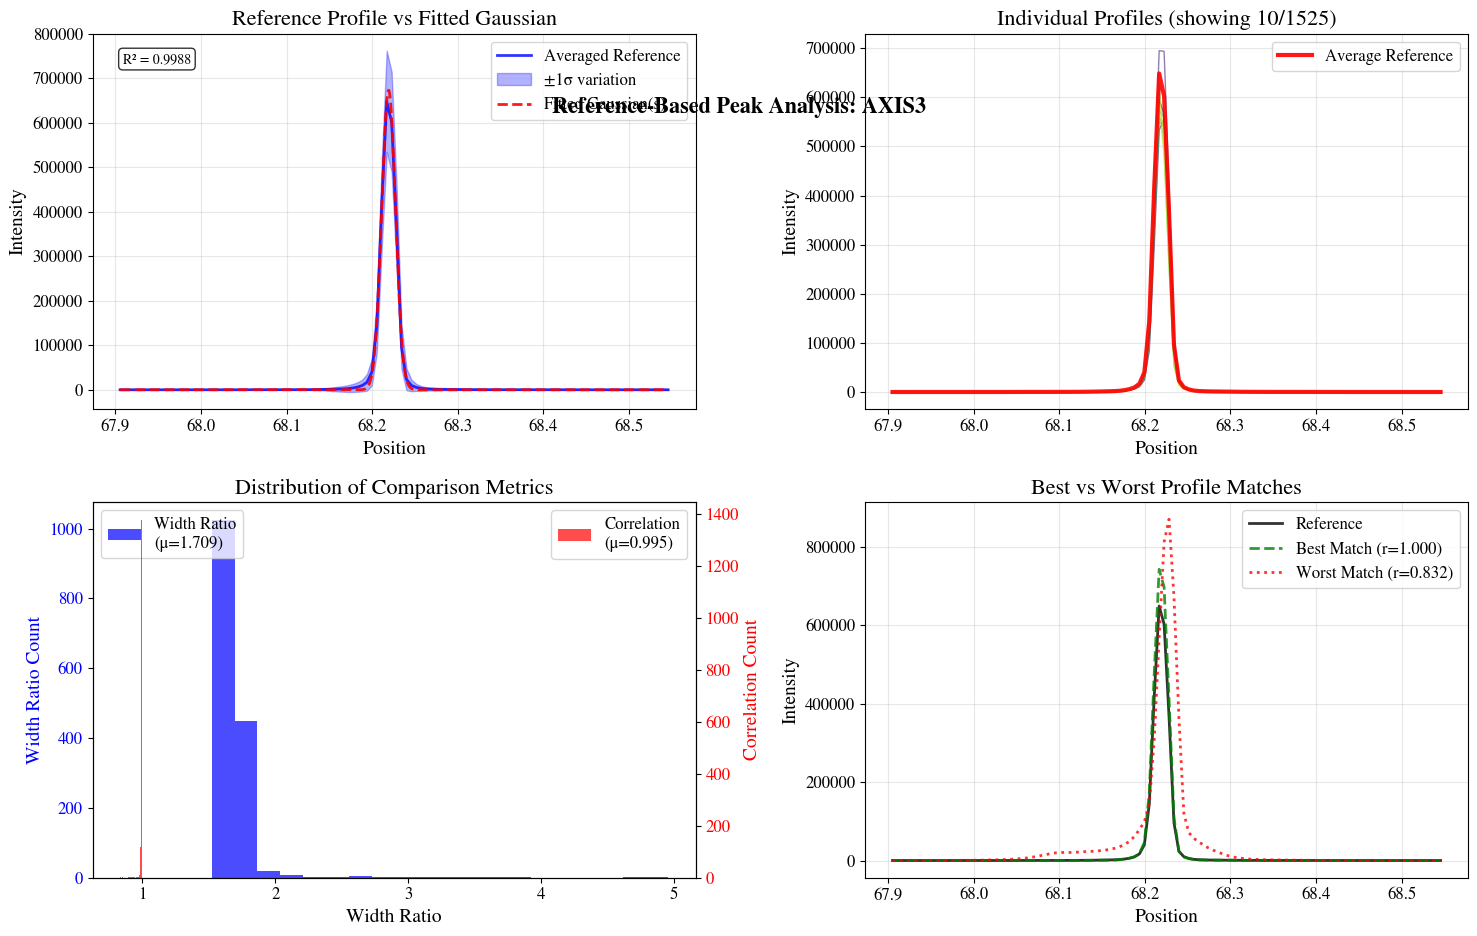

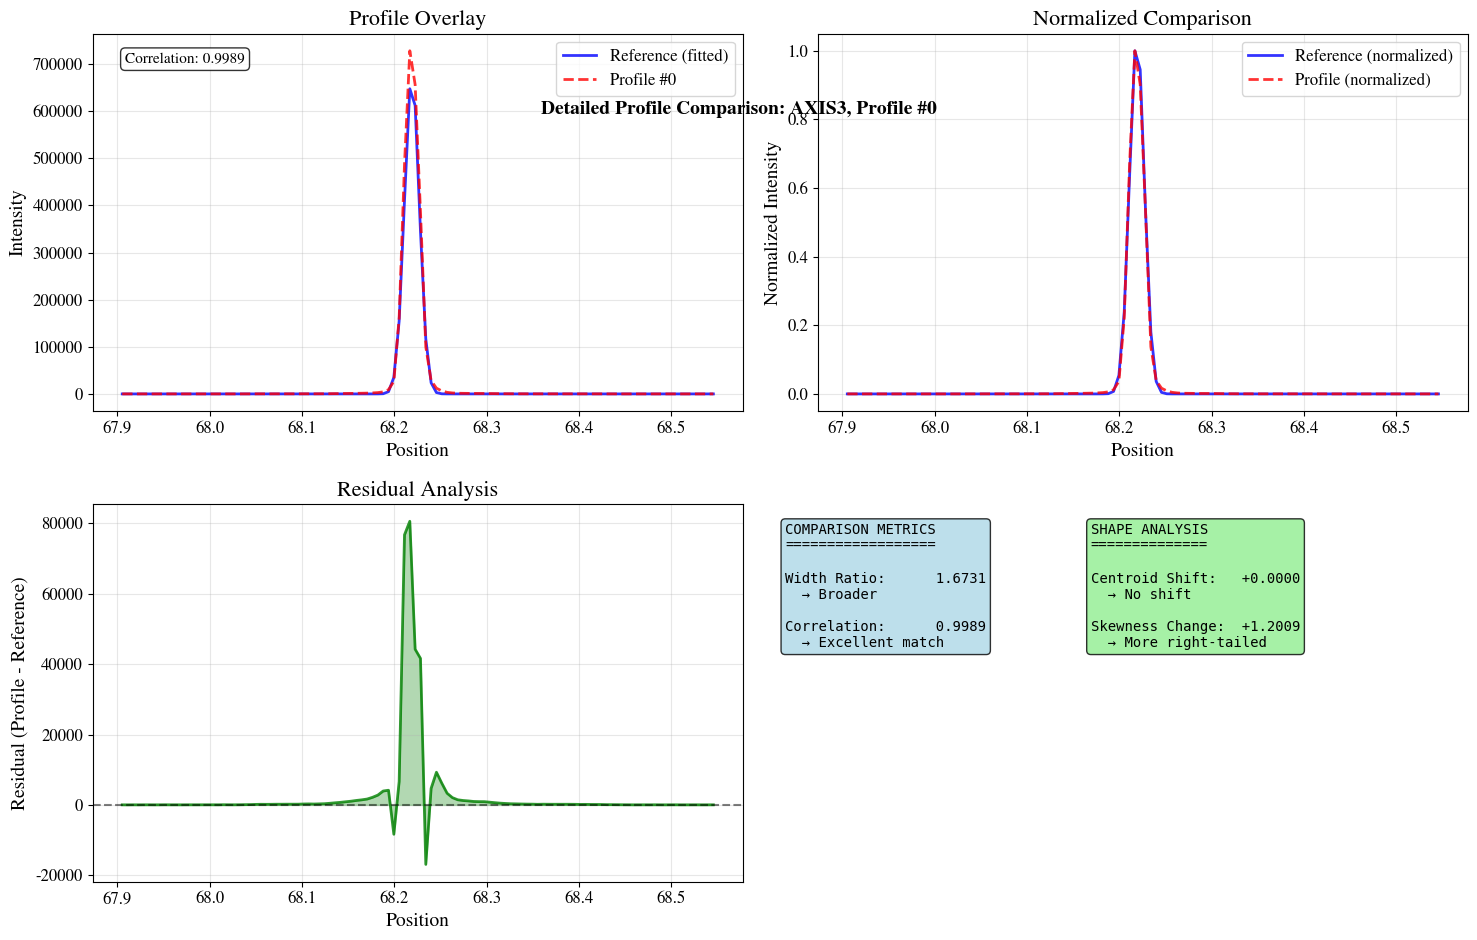

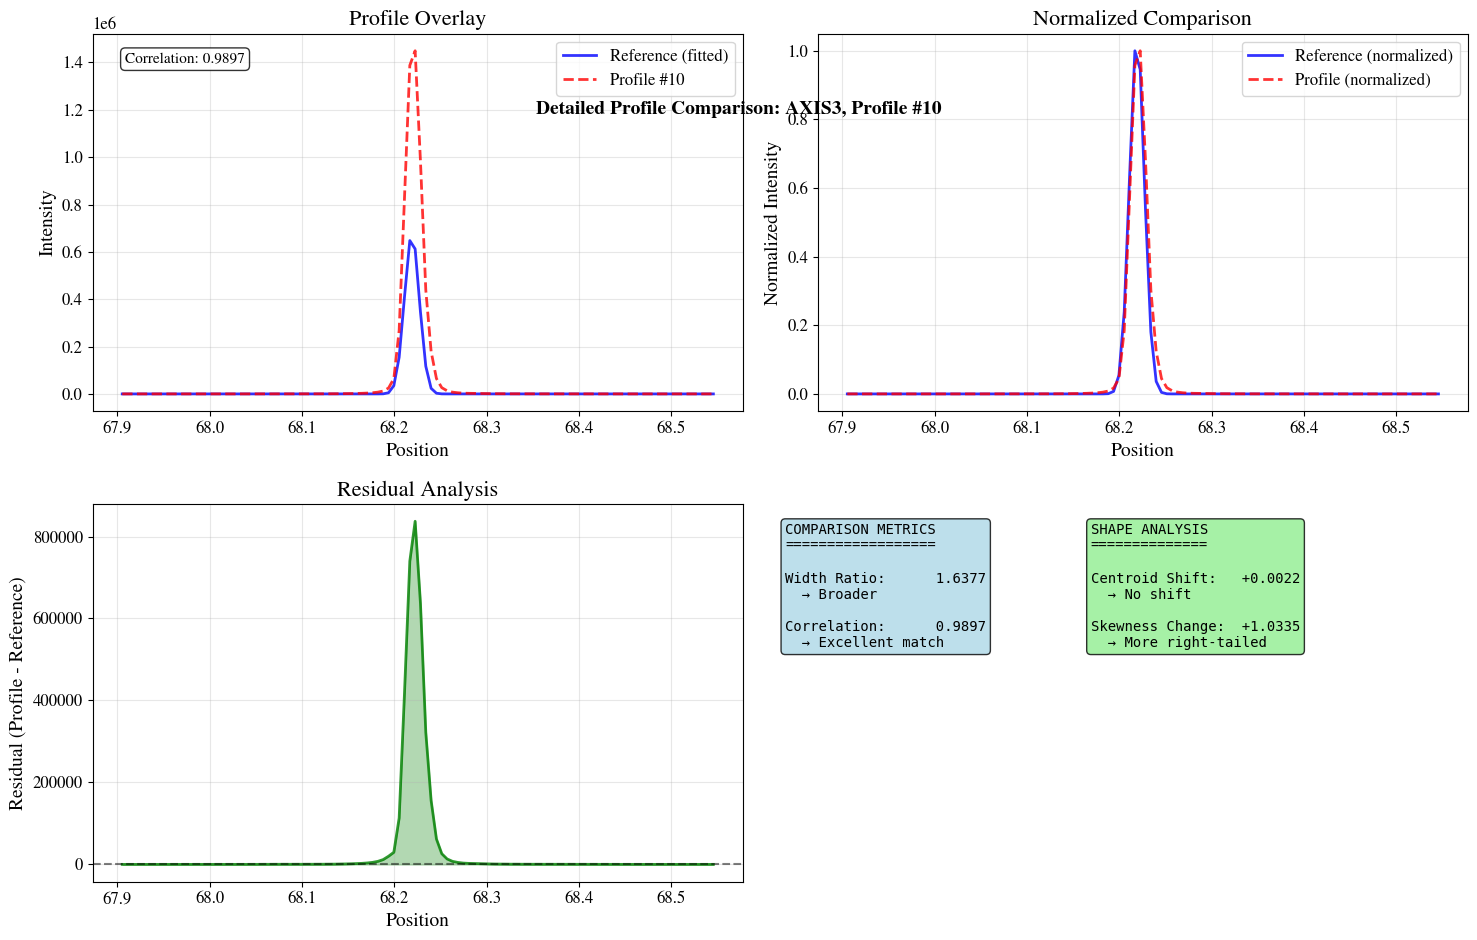

In [26]:
# 1. Quick text overview
quick_reference_overview(analyzer, axis)

# 2. Comprehensive 4-panel visualization
fig1 = visualize_reference_analysis(analyzer, axis)
plt.show()

# 3. Detailed comparison of specific profiles
# Look at profile #0 (first profile)
fig2 = visualize_specific_profile_comparison(analyzer, axis, 0)
plt.show()

# Look at profile #10 (if you have at least 11 profiles)
fig3 = visualize_specific_profile_comparison(analyzer, axis, 10)
plt.show()

In [27]:
# obtain the point-dependent analysis results
from function_1D_comparison import analyze_current_value
needed_results_names = [
    'moment_differences.centroid_diff', 
    'moment_differences.width_ratio', 
    'moment_differences.skewness_diff', 
    'moment_differences.kurtosis_diff', 
    'auc_comparison.auc_ratio', 
    # 'auc_comparison.auc_difference', 
    # 'auc_comparison.auc_relative_diff_percent', 
    # 'auc_comparison.noise_threshold_factor', 
    # 'similarity_measures.correlation', 
    'similarity_measures.cosine_similarity', 
    'similarity_measures.euclidean_distance',
    'similarity_measures.ks_statistic'
]
point_results_all = analyze_current_value(
    comparisons = comparisons,
    S = S,
    metrics_of_interest = needed_results_names,
    verbose = True
)

=== Neighbor-based Difference Analysis ===
Total points: 1525
Using: Point-dependent
Metrics analyzed: 8

similarity_measures.cosine_similarity:
  Mean relative difference: 0.9956 ± 0.0091
  Valid points: 1525/1525

moment_differences.width_ratio:
  Mean relative difference: 1.7090 ± 0.2116
  Valid points: 1525/1525

moment_differences.centroid_diff:
  Mean relative difference: -0.0002 ± 0.0011
  Valid points: 1525/1525

auc_comparison.auc_ratio:
  Mean relative difference: 1.0235 ± 0.2391
  Valid points: 1525/1525



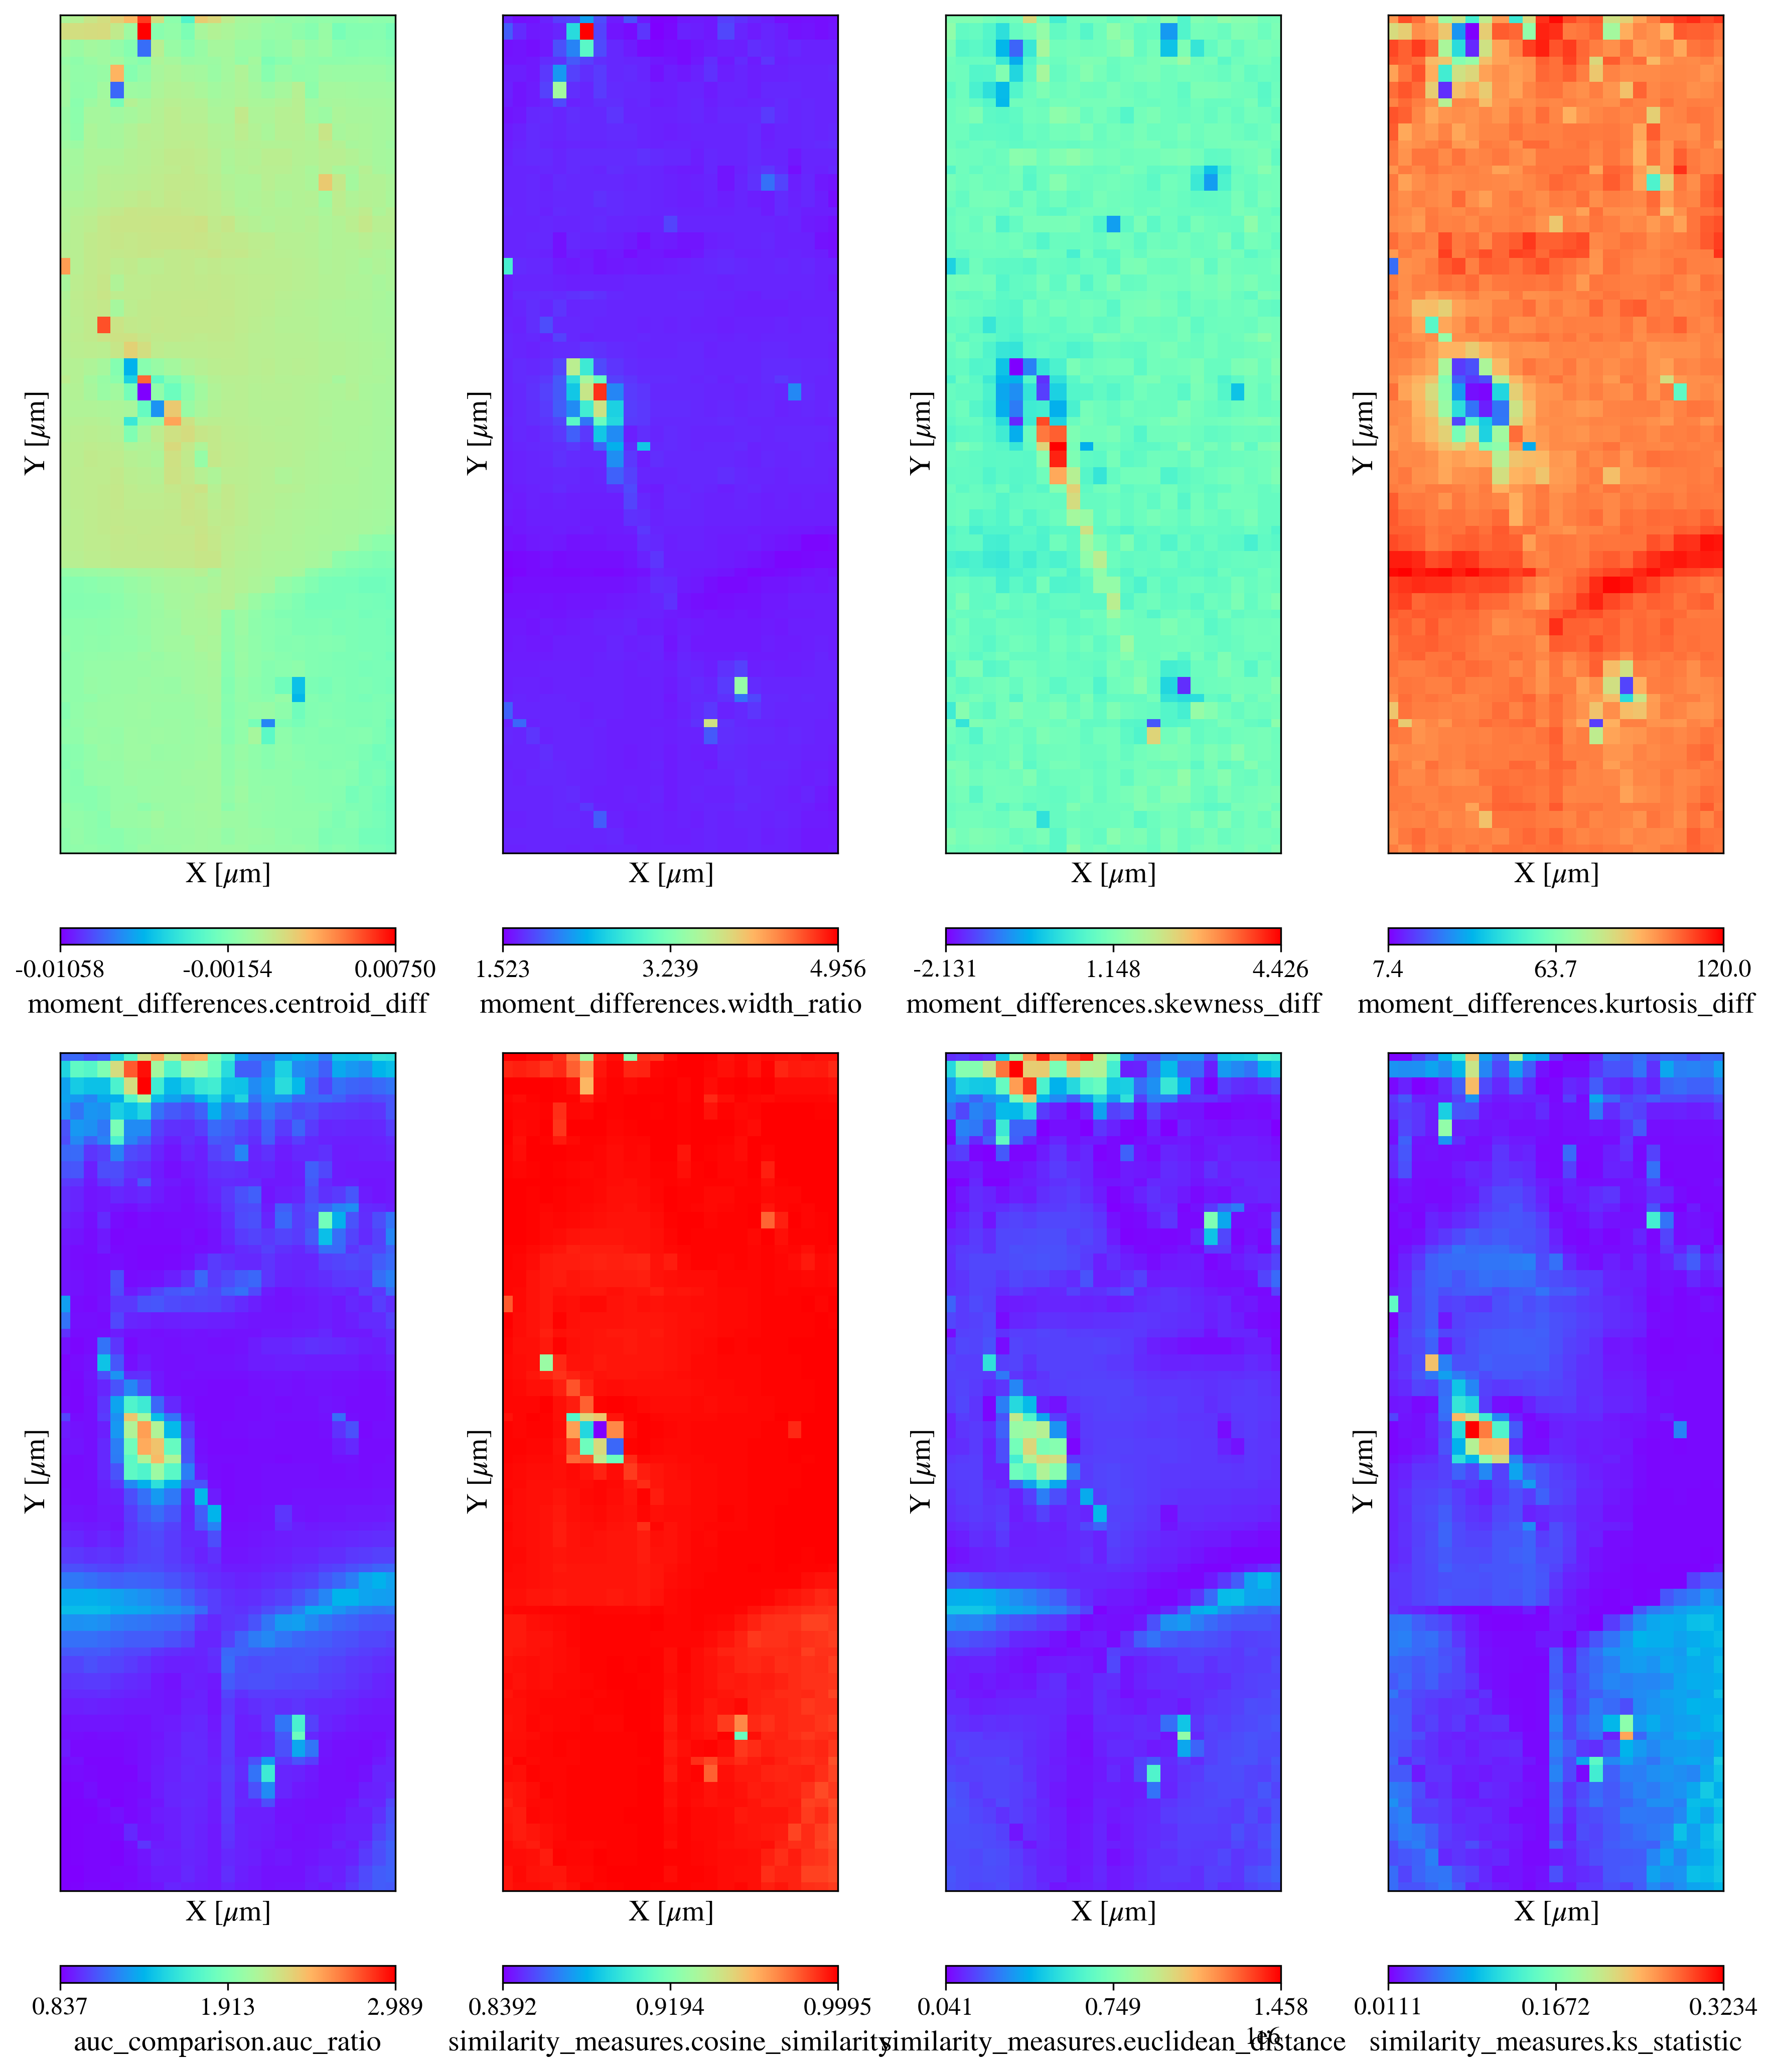

In [28]:
from utilis_plot import sample_plot
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 4, figsize=(12, 14), dpi=300)
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i == len(needed_results_names):
        break
    sample_plot(
        ax
        #, label = 'a'
        ,S = S
        ,data = point_results_all['point_based'][str(needed_results_names[i])]
        ,colorbar_title = str(needed_results_names[i])
            )

In [29]:
# save_results
data_save_target = save_path + f"/{X_type}_directional_features_map.pickle"
results = {
    'point_based_results': point_results_all,
    'names': needed_results_names
}
with open(data_save_target, 'wb') as f:
    pickle.dump(results, f)